# Exploring Natural vs. Anthropogenic CO$_{2}$
After ICDC, we realized that it isn't exactly clear what our residuals represent. For awhile, we portrayed them as simply "natural CO$_{2}$." We realized recently, that embedded in the ensemble mean is a strong seasonal cycle. The trend within the ensemble mean is likely the anthropogenic invasion of carbon, but what is this seasonal cycle? Surely it isn't purely anthropogenic carbon, so these residuals more likely represent variability in natural CO2 due to internally generated variability. 

The goal of this notebook is to use FG_ALT_CO2 output to understand what all of our time series components represent. The same processing has been done to the FG_ALT_CO2 output as other variables: it has been area-weighted over each region and split into the ensemble mean and residuals. The output itself was generated with the same dynamics of each run but with constant pre-industrial CO2 levels. Thus, it represents purely natural CO2 flux. We can take FG_CO2 - FG_ALT_CO2 to accurately extract anthropogenic carbon.

The questions we are trying to answer here are:

1. What do the residuals represent from the FG_CO2 runs?
2. Is there any trend in the FG_ALT_CO2 timeseries?
3. Does the seasonal cycle show up in the FG_ALT_CO2 output? What drives that seasonal cycle?

Once we answer these fundamental questions, we can go on to really quantify and characterize the full time series from the historical runs.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

# Set Parameters

In [2]:
EBU = "CanCS"

# Functions

In [4]:
def load_in_filtered_data(VAR, EBU, AW=True):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

# Load in FG_ALT_CO2 and FG_CO2 Output

In [5]:
alt_forced, alt_residuals, alt_total = load_in_filtered_data('FG_ALT_CO2', EBU)
contemp_forced, contemp_residuals, contemp_total = load_in_filtered_data('FG_CO2', EBU)

# (1) Does the seasonal cycle show up in FG_ALT_CO2?
We are interested in how much of this seasonal cycle in the contemporary FG_CO2 is due to natural carbon fluxes.

In [6]:
# Pull out the ensemble mean from both variables (which should be the seasonal cycle + trend)
contemp_mean = contemp_forced['FG_CO2_AW'].values
natural_mean = alt_forced['FG_ALT_CO2_AW'].values

# Pull out the time component for plotting
t = alt_forced['time'].values

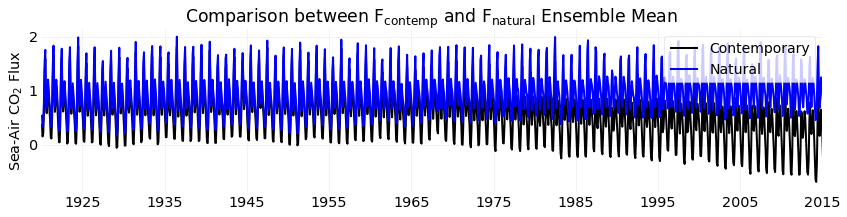

In [7]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)
plt.plot(t, contemp_mean, color='k', linewidth=2, label='Contemporary')
plt.plot(t, natural_mean, color='b', linewidth=2, label='Natural')

ax.set_title('Comparison between F$_{\mathrm{contemp}}$ and F$_{\mathrm{natural}}$ Ensemble Mean')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux')
ax.set(xlim=['1920', '2015'])
legend = ax.legend(loc='upper right', fontsize=14)

#plt.savefig('CalCS_seasonal_cycle_comparison.png',
#             dpi=250, bbox_inches='tight', pad_inches=1)

At first glance, the seasonal cycles look quite similar. It seems as though the deviation is due to a trend in the contemporary CO$_{2}$ flux cycle. To test this hypothesis, I will remove a 4th order polynomial fit (seems to be standard in climate literature, such as Hawkins papers and Deser papers) and then correlate the two time series to see how much of the variability is explained. We can probably assume that any residual is due to a seasonal cycle from anthropogenic CO$_{2}$.

In [8]:
import numpy.polynomial.polynomial as poly
def remove_polynomial_fit(data, order=4):
    x = np.arange(0, len(data), 1)
    coefs = poly.polyfit(x, data, order)
    line_fit = poly.polyval(x, coefs)
    return (data - line_fit), coefs

In [9]:
# Remove 4th order polynomial from each time series and re-plot.
detrended_contemp, contemp_coefs = remove_polynomial_fit(contemp_mean)
detrended_natural, nat_coefs = remove_polynomial_fit(natural_mean)

# Generate anthropogenic time series from difference between these two
anthropogenic = detrended_contemp - detrended_natural

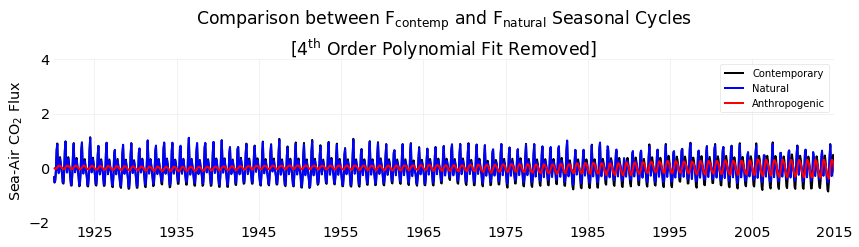

In [16]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)
plt.plot(t, detrended_contemp, color='k', linewidth=2, label='Contemporary')
plt.plot(t, detrended_natural, color='b', linewidth=2, label='Natural')
plt.plot(t, anthropogenic, color='r', linewidth=2, label='Anthropogenic')

ax.set_title('Comparison between F$_{\mathrm{contemp}}$ and F$_{\mathrm{natural}}$ Seasonal Cycles' + '\n' +
             '[4$^{\mathrm{th}}$ Order Polynomial Fit Removed]')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux')
ax.set(ylim=[-2, 4], xlim=['1920', '2015'])
legend = ax.legend(loc='upper right')

#plt.savefig('CanCS_seasonal_cycle_comparison_notrend.png', 
#             dpi=250, bbox_inches='tight', pad_inches=1)

After removing a 4th order polynomial, these time series look a lot more similar. Interestingly, the detrended anthropogenic seasonal cycle becomes larger over time. **A potential area to explore for each system is if the natural component of the seasonal cycle maintains a constant amplitude, but the total (contemporary) seasonal cycle grows in amplitude due to this anthropogenic invasion**.

Before comparing the trends themselves, let's correlate these detrended seasonal cycles. I'll simply run a correlation between the detrended time series and look at what comes out.

In [11]:
from scipy import stats
slope, intercept, r, p, std_err = stats.linregress(detrended_natural, detrended_contemp)
print('Slope     : ' + str(slope))
print('R         : ' + str(r))
print('R Squared : ' + str(r**2))
print('p         : ' + str(p))

Slope     : 1.05827285566
R         : 0.960112322684
R Squared : 0.921815672169
p         : 0.0


### Question: 
Does the seasonal cycle show up in FG_ALT_CO2?

### Answer:
Yes. It seems that the FG_CO2 ensemble mean periodic component is driven by the seasonal cycle of natural CO2. After detrending the contemporary (FG_CO2) and natural (FG_ALT_CO2) time series ensemble means, we find that 99.6% of the variability of the contemporary time series is explained by the natural time series. The interesting thing is that it seems as though the total amplitude might slightly grow, and it could be driven by the anthropogenic perturbation. This is something that can be explored further for each system.

# (2) Is there a (significant) trend in FG_ALT_CO2?
There exists a trend in the contemporary cycle, which is assumped to be driven by the anthropogenic CO$_{2}$. However, is there some sort of drift in the natural CO$_{2}$ flux that could explain this?

In [12]:
def linear_regression(data):
    """
    Performs a linear regression on the time series and returns the linear fit time series
    as well as the slope across the full time series and the p-value.
    """
    x = np.arange(0, len(data), 1)
    coefs = poly.polyfit(x, data, 1)
    line_fit = poly.polyval(x, coefs)
    slope, _, _, p, _ = stats.linregress(x, data)
    slope = slope*(len(data)/12)
    return line_fit, slope, p

In [13]:
anthropogenic_mean = contemp_mean - natural_mean

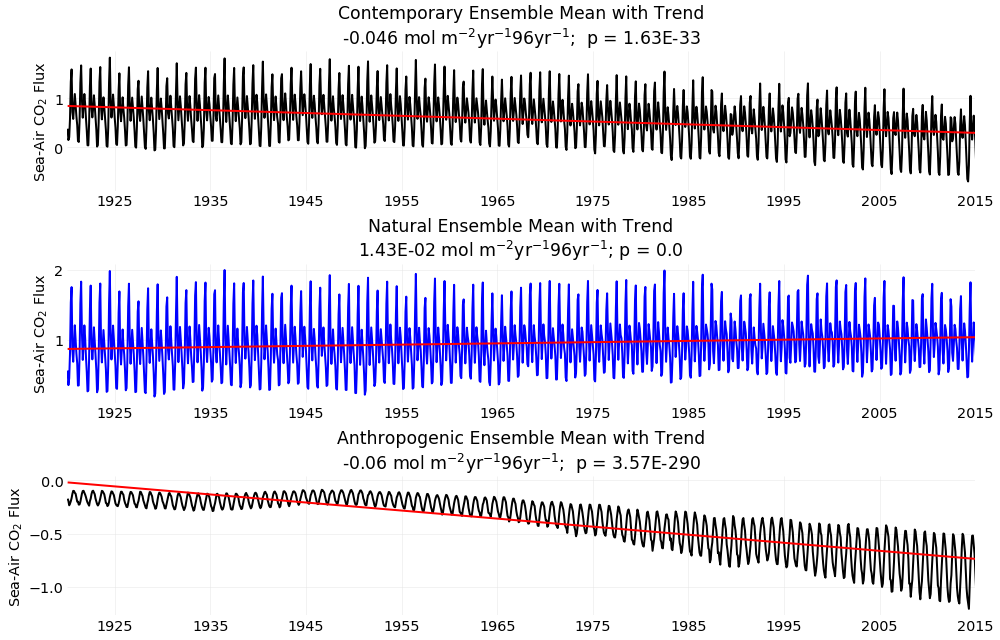

In [15]:
def plot_with_trend(x, y, color='k', name='Contemporary'):
    fit, slope, p = linear_regression(y)
    plt.plot(x, y, color=color, linewidth=2)
    plt.plot(x, fit, color='r', linewidth=2)
    ax.set_ylabel('Sea-Air CO$_{2}$ Flux')
    ax.set(xlim=['1920', '2015'])
    ax.set_title(name + ' Ensemble Mean with Trend' + '\n' +
                 str(slope.round(3)) + ' mol m$^{-2}$yr$^{-1}$96yr$^{-1}$; ' +
                 ' p = ' + '%.2E' % p)
    return slope, p

fig = plt.figure(figsize=(14,9))
# Contemporary Time Series
ax = plt.subplot(311)
plot_with_trend(t, contemp_mean)

# Natural Time Series
ax = plt.subplot(312)
nat_slope, nat_p = plot_with_trend(t, natural_mean, color='blue')
ax.set_title('Natural Ensemble Mean with Trend' + '\n' + 
             '%.2E' % nat_slope + ' mol m$^{-2}$yr$^{-1}$96yr$^{-1}$; p = ' + 
             str(nat_p.round(2)))

# Anthropogenic Time Series
ax = plt.subplot(313)
plot_with_trend(t, anthropogenic_mean, name='Anthropogenic')

fig.tight_layout()

#plt.savefig('CanCS_trend_comparison.png', 
#             dpi=250, bbox_inches='tight', pad_inches=1)

The above two plots show the ensemble mean for the contemporary CO$_{2}$ flux (FGCO2; top) and the natural CO$_{2}$ flux (FG$\_$ALT$\_$CO2; bottom). Recall that the seasonal cycle itself is mostly produced by the natural CO$_{2}$ cycle. The question here is if the trend experienced in the contemporary CO$_{2}$ flux has anything to do with the natural flux, and that seems to not be the case. 

We find in the contemporary ensemble mean a very minor trend (-0.03mol/m2/yr for the whole historical period) that is statistically significant. In comparison, we find an extremely small trend in the natural CO2 flux (-0.00085mol/m2/yr for the whole historical period) and it is NOT significant.

### Most of the seasonal cycle is due to the natural flux of CO$_{2}$. Only a minor portion of it is due to anthropogenic CO$_{2}$ and the contemporary flux seems to be growing over time due to the anthropogenic perturbation.

### There exists a very small, but statistically significant, trend in the contemporary CO$_{2}$ towards a larger sink of carbon. That trend is solely due to anthropogenic carbon.

# (3) What do the residuals represent?
When we look at residuals in the contemporary CO2 flux, is it purely natural, or is there also some internally generated variable that influences the anthropogenic flux?

In [25]:
# Load in the original residual output again for clarity.
alt_forced, alt_residuals, alt_total = load_in_filtered_data('FG_ALT_CO2', EBU)
contemp_forced, contemp_residuals, contemp_total = load_in_filtered_data('FG_CO2', EBU)

# Create three partitions of residuals
contemp_residuals = contemp_residuals['FG_CO2_AW'].values
natural_residuals = alt_residuals['FG_ALT_CO2_AW'].values
anthrop_residuals = contemp_residuals - natural_residuals

All of these residuals are dimensions 34x1152. In the previous case, we were only working with 1D time series data, since it was the ensemble mean. Now we are working with all ensemble members.

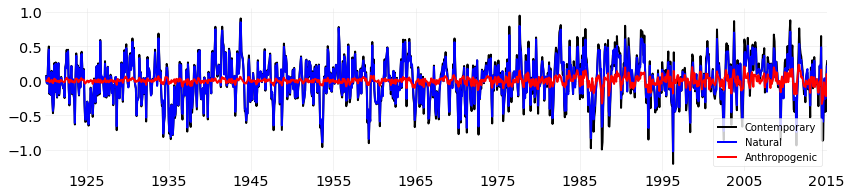

In [26]:
# For a test case, let's just plot from one member.
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)

plt.plot(t, contemp_residuals[0], color='k', linewidth=2, label='Contemporary')
plt.plot(t, natural_residuals[0], color='b', linewidth=2, label='Natural')
plt.plot(t, anthrop_residuals[0], color='r', linewidth=2, label='Anthropogenic')

ax.set(xlim=['1920','2015'])
ax.legend()

Does this relationship hold for many simulations?

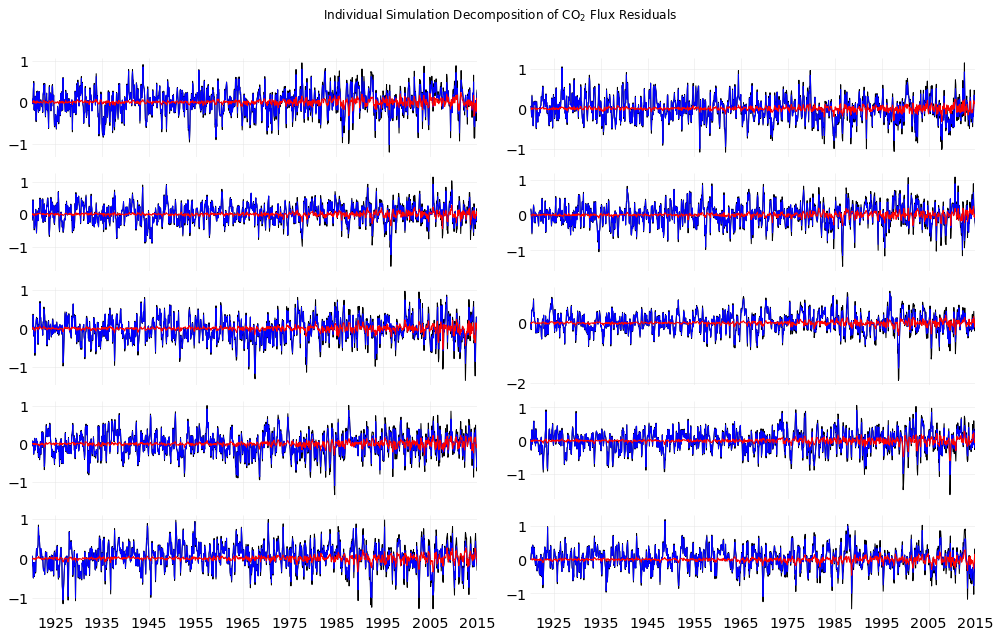

In [29]:
def residual_decomposition_plot(t, contemp, natural, anthro, legend=False):
    p1 = plt.plot(t, contemp, color='k', linewidth=1, label='Contemporary')
    p2 = plt.plot(t, natural, color='b', linewidth=1, label='Natural')
    p3 = plt.plot(t, anthro, color='r', linewidth=1, label='Anthropogenic')
    ax.set(xlim=['1920', '2015'])
    if legend == True:
        ax.legend(loc='upper right')
    return p1, p2, p3

fig = plt.figure(figsize=(14,9))
for idx in np.arange(0, 10, 1):
    ax = plt.subplot(5, 2, idx+1)
    p1,p2,p3 = residual_decomposition_plot(t, contemp_residuals[idx], natural_residuals[idx],
                                anthrop_residuals[idx])
    if idx < 8:
        ax.set_xticklabels('')
fig.tight_layout()        
fig.suptitle('Individual Simulation Decomposition of CO$_{2}$ Flux Residuals')
fig.subplots_adjust(top=0.90)

plt.savefig('CalCS_residual_comparison.png', transparent=True,
             dpi=500, bbox_inches='tight', pad_inches=1)

The eye test shows that these internally generated residuals ("internally generated variability in CO2 fluxes") are due primarily to natural CO2, but as time evolves, anthropogenic CO2 becomes increasingly important. This was an important excursion to take with the data, to really get all the definitions correct.

For every EBUS contemporary CO$_{2}$ flux time series, we now have a few components to characterize historically:

1. The "level" or mean state of our region. This is simply the mean across the whole time series. Is this generally an outgassing or uptake site?
2. The "trend" of the region. We have shown here that this is purely due to the anthropogenic invasion of carbon and should be toward a sink in every location.
3. The "seasonal" component of the region. What is the mean amplitude of the seasonal cycle for each region (derived from the detrended ensemble mean)? We have shown here that this is primarily natural carbon, but as time goes on, part of the seasonal cycle is due to anthropogenic carbon.
4. The "residual" component for each simulation. This is the internally generated variabiliy, which is primarily natural, but also includes some anthropogenic carbon. This is what generally controls the "variability" of the system we are trying to get at with the large ensemble.